# Chapter 19: Code optimization

Robert Johansson

Source code listings for [Numerical Python - A Practical Techniques Approach for Industry](http://www.apress.com/9781484205549) (ISBN 978-1-484205-54-9).

The source code listings can be downloaded from http://www.apress.com/9781484205549

In [1]:
import numba

In [2]:
import pyximport

In [3]:
import cython

In [4]:
import numpy as np

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Numba

In [6]:
np.random.seed(0)

In [7]:
data = np.random.randn(50000)

In [8]:
def py_sum(data):
    s = 0
    for d in data:
        s += d
    return s

In [9]:
def py_cumsum(data):
    out = np.zeros(len(data), dtype=np.float64)
    s = 0 
    for n in range(len(data)):
        s += data[n]
        out[n] = s

    return out

In [10]:
%timeit py_sum(data)

100 loops, best of 3: 7.99 ms per loop


In [11]:
assert abs(py_sum(data) - np.sum(data)) < 1e-10

In [12]:
%timeit np.sum(data)

10000 loops, best of 3: 28.8 µs per loop


In [13]:
%timeit py_cumsum(data)

100 loops, best of 3: 13.1 ms per loop


In [14]:
assert np.allclose(np.cumsum(data), py_cumsum(data))

In [15]:
%timeit np.cumsum(data)

10000 loops, best of 3: 146 µs per loop


In [16]:
@numba.jit
def jit_sum(data):
    s = 0 
    for d in data:
        s += d

    return s

In [17]:
assert abs(jit_sum(data) - np.sum(data)) < 1e-10

In [18]:
%timeit jit_sum(data)

10000 loops, best of 3: 47.4 µs per loop


In [19]:
jit_cumsum = numba.jit()(py_cumsum)

In [20]:
assert np.allclose(np.cumsum(data), jit_cumsum(data))

In [21]:
%timeit jit_cumsum(data)

10000 loops, best of 3: 78.9 µs per loop


## Julia fractal

In [22]:
def py_julia_fractal(z_re, z_im, j):
    for m in range(len(z_re)):
        for n in range(len(z_im)):
            z = z_re[m] + 1j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if np.abs(z) > 2.0:
                #if (z.real * z.real + z.imag * z.imag) > 4.0:  # a bit faster
                    j[m, n] = t
                    break

In [23]:
jit_julia_fractal = numba.jit(nopython=True)(py_julia_fractal)

In [24]:
N = 1024
j = np.zeros((N, N), np.int64)
z_real = np.linspace(-1.5, 1.5, N)
z_imag = np.linspace(-1.5, 1.5, N)

In [25]:
jit_julia_fractal(z_real, z_imag, j)

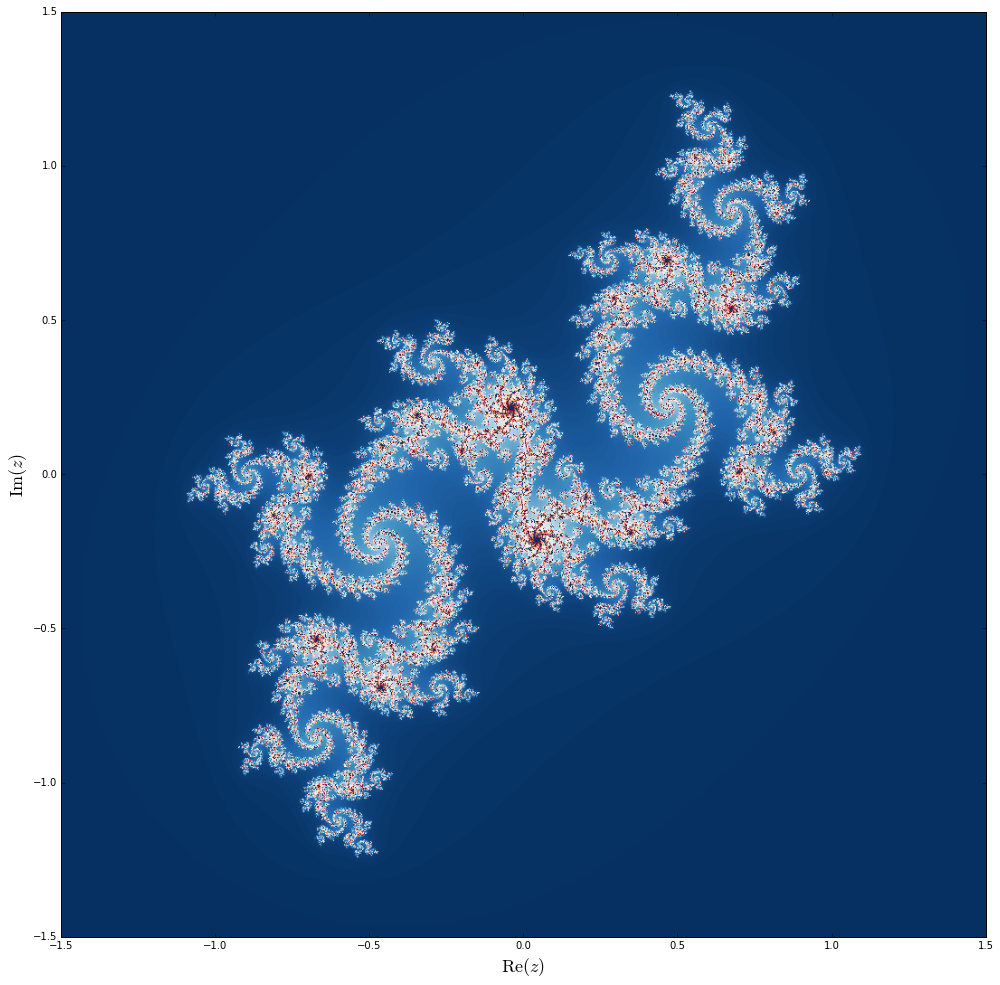

In [26]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(j, cmap=plt.cm.RdBu_r,
          extent=[-1.5, 1.5, -1.5, 1.5])
ax.set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
ax.set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
fig.tight_layout()
fig.savefig("ch19-numba-julia-fractal.pdf")

In [27]:
%timeit py_julia_fractal(z_real, z_imag, j)

1 loops, best of 3: 59.6 s per loop


In [28]:
%timeit jit_julia_fractal(z_real, z_imag, j)

10 loops, best of 3: 126 ms per loop


## Vectorize

In [29]:
def py_Heaviside(x):
    if x == 0.0:
        return 0.5
    
    if x < 0.0:
        return 0.0
    else:
        return 1.0

In [30]:
x = np.linspace(-2, 2, 50001)

In [31]:
%timeit [py_Heaviside(xx) for xx in x]

10 loops, best of 3: 20 ms per loop


In [32]:
np_vec_Heaviside = np.vectorize(py_Heaviside)

In [33]:
np_vec_Heaviside(x)

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [34]:
%timeit np_vec_Heaviside(x)

100 loops, best of 3: 12 ms per loop


In [35]:
def np_Heaviside(x):
    return (x > 0.0) + (x == 0.0)/2.0

In [36]:
%timeit np_Heaviside(x)

1000 loops, best of 3: 255 µs per loop


In [37]:
@numba.vectorize([numba.float32(numba.float32),
                  numba.float64(numba.float64)])
def jit_Heaviside(x):
    if x == 0.0:
        return 0.5
    
    if x < 0:
        return 0.0
    else:
        return 1.0

In [38]:
%timeit jit_Heaviside(x)

10000 loops, best of 3: 43.6 µs per loop


In [39]:
jit_Heaviside([-1, -0.5, 0.0, 0.5, 1.0])

array([ 0. ,  0. ,  0.5,  1. ,  1. ])

# Cython

In [40]:
!rm cy_sum.*

In [41]:
%%writefile cy_sum.pyx

def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

Writing cy_sum.pyx


In [42]:
!cython cy_sum.pyx

In [43]:
# 5 lines of python code -> 1470 lines of C code ...
!wc cy_sum.c

    1519    5191   57293 cy_sum.c


In [44]:
%%writefile setup.py

from distutils.core import setup
from Cython.Build import cythonize

import numpy as np
setup(ext_modules=cythonize('cy_sum.pyx'),
      include_dirs=[np.get_include()],
      requires=['Cython', 'numpy'] )

Overwriting setup.py


In [45]:
!python setup.py build_ext --inplace > /dev/null

cy_sum.c:1377:28: warning: unused function '__Pyx_PyObject_AsString' [-Wunused-function]
static CYTHON_INLINE char* __Pyx_PyObject_AsString(PyObject* o) {
                           ^
cy_sum.c:1374:32: warning: unused function '__Pyx_PyUnicode_FromString' [-Wunused-function]
static CYTHON_INLINE PyObject* __Pyx_PyUnicode_FromString(const char* c_str) {
                               ^
cy_sum.c:322:29: warning: unused function '__Pyx_Py_UNICODE_strlen' [-Wunused-function]
static CYTHON_INLINE size_t __Pyx_Py_UNICODE_strlen(const Py_UNICODE *u)
                            ^
cy_sum.c:1439:26: warning: unused function '__Pyx_PyObject_IsTrue' [-Wunused-function]
static CYTHON_INLINE int __Pyx_PyObject_IsTrue(PyObject* x) {
                         ^
cy_sum.c:1489:33: warning: unused function '__Pyx_PyIndex_AsSsize_t' [-Wunused-function]
static CYTHON_INLINE Py_ssize_t __Pyx_PyIndex_AsSsize_t(PyObject* b) {
                                ^
cy_sum.c:1514:33: warning: unused function '__Pyx_P

In [46]:
from cy_sum import cy_sum

In [47]:
cy_sum(data)

-189.70046227549025

In [48]:
%timeit cy_sum(data)

100 loops, best of 3: 4.96 ms per loop


In [49]:
%timeit py_sum(data)

100 loops, best of 3: 8.09 ms per loop


In [50]:
%%writefile cy_cumsum.pyx

cimport numpy
import numpy

def cy_cumsum(data):
    out = numpy.zeros_like(data)
    s = 0 
    for n in range(len(data)):
        s += data[n]
        out[n] = s

    return out

Overwriting cy_cumsum.pyx


In [51]:
pyximport.install(setup_args={'include_dirs': np.get_include()});

In [52]:
pyximport.install(setup_args=dict(include_dirs=np.get_include()));

In [53]:
from cy_cumsum import cy_cumsum

In [54]:
%timeit cy_cumsum(data)

100 loops, best of 3: 6.32 ms per loop


In [55]:
%timeit py_cumsum(data)

100 loops, best of 3: 13.4 ms per loop


## Using IPython cython command

In [56]:
%load_ext cython

In [57]:
%%cython -a
def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

In [58]:
%timeit cy_sum(data)

100 loops, best of 3: 4.97 ms per loop


In [59]:
%timeit py_sum(data)

100 loops, best of 3: 7.82 ms per loop


In [60]:
assert np.allclose(np.sum(data), cy_sum(data))

In [61]:
%%cython -a
cimport numpy
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_sum(numpy.ndarray[numpy.float64_t, ndim=1] data):
    cdef numpy.float64_t s = 0.0
    cdef int n, N = len(data)
    for n in range(N):
        s += data[n]
    return s

In [62]:
%timeit cy_sum(data)

10000 loops, best of 3: 47.5 µs per loop


In [63]:
%timeit jit_sum(data)

10000 loops, best of 3: 47.3 µs per loop


In [64]:
%timeit np.sum(data)

10000 loops, best of 3: 28.4 µs per loop


## Cummulative sum

In [65]:
%%cython -a
cimport numpy
import numpy
cimport cython

ctypedef numpy.float64_t FTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_cumsum(numpy.ndarray[FTYPE_t, ndim=1] data):
    cdef int N = data.size
    cdef numpy.ndarray[FTYPE_t, ndim=1] out = numpy.zeros(N, dtype=data.dtype)
    cdef numpy.float64_t s = 0.0
    for n in range(N):
        s += data[n]
        out[n] = s
    return out

In [66]:
%timeit py_cumsum(data)

100 loops, best of 3: 13.6 ms per loop


In [67]:
%timeit cy_cumsum(data)

The slowest run took 23.50 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 69.7 µs per loop


In [68]:
%timeit jit_cumsum(data)

10000 loops, best of 3: 76.6 µs per loop


In [69]:
%timeit np.cumsum(data)

10000 loops, best of 3: 155 µs per loop


In [70]:
assert np.allclose(cy_cumsum(data), np.cumsum(data))

## Fused types

In [71]:
py_sum([1.0, 2.0, 3.0, 4.0, 5.0])

15.0

In [72]:
py_sum([1, 2, 3, 4, 5])

15

In [73]:
cy_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [74]:
cy_sum(np.array([1, 2, 3, 4, 5]))

ValueError: Buffer dtype mismatch, expected 'float64_t' but got 'long'

In [75]:
%%cython -a
cimport numpy
cimport cython

ctypedef fused I_OR_F_t:
    numpy.int64_t 
    numpy.float64_t 

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_fused_sum(numpy.ndarray[I_OR_F_t, ndim=1] data):
    cdef I_OR_F_t s = 0
    cdef int n, N = data.size
    for n in range(N):
        s += data[n]
    return s

In [76]:
cy_fused_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [77]:
cy_fused_sum(np.array([1, 2, 3, 4, 5]))

15

## Julia fractal

In [78]:
%%cython -a
cimport numpy
cimport cython

ctypedef numpy.int64_t ITYPE_t
ctypedef numpy.float64_t FTYPE_t

cpdef inline double abs2(double complex z):
    return z.real * z.real + z.imag * z.imag

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_julia_fractal(numpy.ndarray[FTYPE_t, ndim=1] z_re, 
                     numpy.ndarray[FTYPE_t, ndim=1] z_im, 
                     numpy.ndarray[ITYPE_t, ndim=2] j):
    cdef int m, n, t, M = z_re.size, N = z_im.size
    cdef double complex z
    for m in range(M):
        for n in range(N):
            z = z_re[m] + 1.0j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if abs2(z) > 4.0:
                    j[m, n] = t
                    break

In [79]:
N = 1024

In [80]:
j = np.zeros((N, N), dtype=np.int64)

In [81]:
z_real = np.linspace(-1.5, 1.5, N)

In [82]:
z_imag = np.linspace(-1.5, 1.5, N)

In [83]:
%timeit cy_julia_fractal(z_real, z_imag, j)

10 loops, best of 3: 117 ms per loop


In [84]:
%timeit jit_julia_fractal(z_real, z_imag, j)

10 loops, best of 3: 126 ms per loop


In [85]:
j1 = np.zeros((N, N), dtype=np.int64)

In [86]:
cy_julia_fractal(z_real, z_imag, j1)

In [87]:
j2 = np.zeros((N, N), dtype=np.int64)

In [88]:
jit_julia_fractal(z_real, z_imag, j2)

In [89]:
assert np.allclose(j1, j2)

## Calling C function

In [90]:
%%cython

cdef extern from "math.h":
     double acos(double)

def cy_acos1(double x):
    return acos(x)

In [91]:
%timeit cy_acos1(0.5)

The slowest run took 22.38 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 95.9 ns per loop


In [92]:
%%cython

from libc.math cimport acos

def cy_acos2(double x):
    return acos(x)

In [93]:
%timeit cy_acos2(0.5)

The slowest run took 24.16 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 88.8 ns per loop


In [94]:
from numpy import arccos

In [95]:
%timeit arccos(0.5)

The slowest run took 24.56 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 932 ns per loop


In [96]:
from math import acos

In [97]:
%timeit acos(0.5)

The slowest run took 21.63 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 99.2 ns per loop


In [98]:
assert cy_acos1(0.5) == acos(0.5)

In [99]:
assert cy_acos2(0.5) == acos(0.5)

# Versions

In [100]:
%reload_ext version_information

In [101]:
%version_information numpy, cython, numba, matplotlib

Software,Version
Python,2.7.10 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython,3.2.1
OS,Darwin 14.1.0 x86_64 i386 64bit
numpy,1.9.2
cython,0.22.1
numba,0.20.0
matplotlib,1.4.3
